# <ins> HeartRate Detection Algorithm </ins>

In [1]:
# Project Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from scipy import signal, ndimage
import os

CSV_FILE_NAME = '2023-05-11-001S-01-14-03-S'
CSV_FILE_EXT = '.csv'
CSV_FILE_PATH = CSV_FILE_NAME + CSV_FILE_EXT
CSV_VALID_FOLDER_NAME = 'ValidCSVFiles'

### Helper Functions

In [2]:
def merge_ranges(ranges):
    """
    Merge overlapping ranges in a list of tuples.
    Args:ranges:A list of tuples representing ranges, where each tuple contains
                two integers representing the start and end points of the range.
    Returns:    A list of tuples representing the merged ranges, where each tuple contains
                two integers representing the start and end points of the range.
    Example:    Input ranges:  [(0, 5), (601, 783), (691, 789), (587, 744)]
                Merged ranges:  [(0, 5), (587, 789)]
    """
    # Check if the ranges list is empty
    if not ranges:
        return ranges
    
    # Sort the ranges in ascending order based on their start points
    ranges.sort()
    # Initialize the merged ranges list with the first range in the list
    merged = [ranges[0]]
    # Loop through the remaining ranges in the list
    for r in ranges[1:]:
        if r[0] <= merged[-1][1]:
            # If the current range overlaps with the last merged range, merge them
            merged[-1] = (merged[-1][0], max(merged[-1][1], r[1]))
        else:
            # If the current range doesn't overlap with the last merged range, add it to the merged list
            merged.append(r)
    # Return the merged ranges list
    return merged

def remove_small_ranges(ranges, minSampleCount):
    """
    Remove ranges with less than minSampleCount samples in a list of tuples.

    Args:
        ranges: A list of tuples representing ranges, where each tuple contains
                two integers representing the start and end points of the range.

    Returns:
        A list of tuples representing the ranges with more than 50 samples, where
        each tuple contains two integers representing the start and end points of
        the range.

    """
    # Initialize the filtered ranges list
    filtered = []
    # Loop through the ranges in the input list
    for r in ranges:
        # Calculate the number of samples in the current range
        samples = r[1] - r[0] + 1
        # If the number of samples is greater than or equal to 50, add the range to the filtered list
        if samples >= minSampleCount:
            filtered.append(r)
    # Return the filtered ranges list
    return filtered
    

### 1. Detect Motion Ranges in PPG CSV File

A_x_mean: 0.5715488842747594
A_x_std: 4.298281459598913
A_x_threshold: 17.76467472267041
A_y_mean: 0.6167890178011258
A_y_std: 5.186046330914358
A_y_threshold: 21.360974341458558
A_z_mean: 0.9937667374889689
A_z_std: 7.906434343468929
A_z_threshold: 32.619504111364684
A_x_high_fluctuation_ranges:  [(0, 40)]
A_y_high_fluctuation_ranges:  [(0, 37)]
A_z_high_fluctuation_ranges:  [(0, 39)]
Motion Ranges:  [(0, 240)]


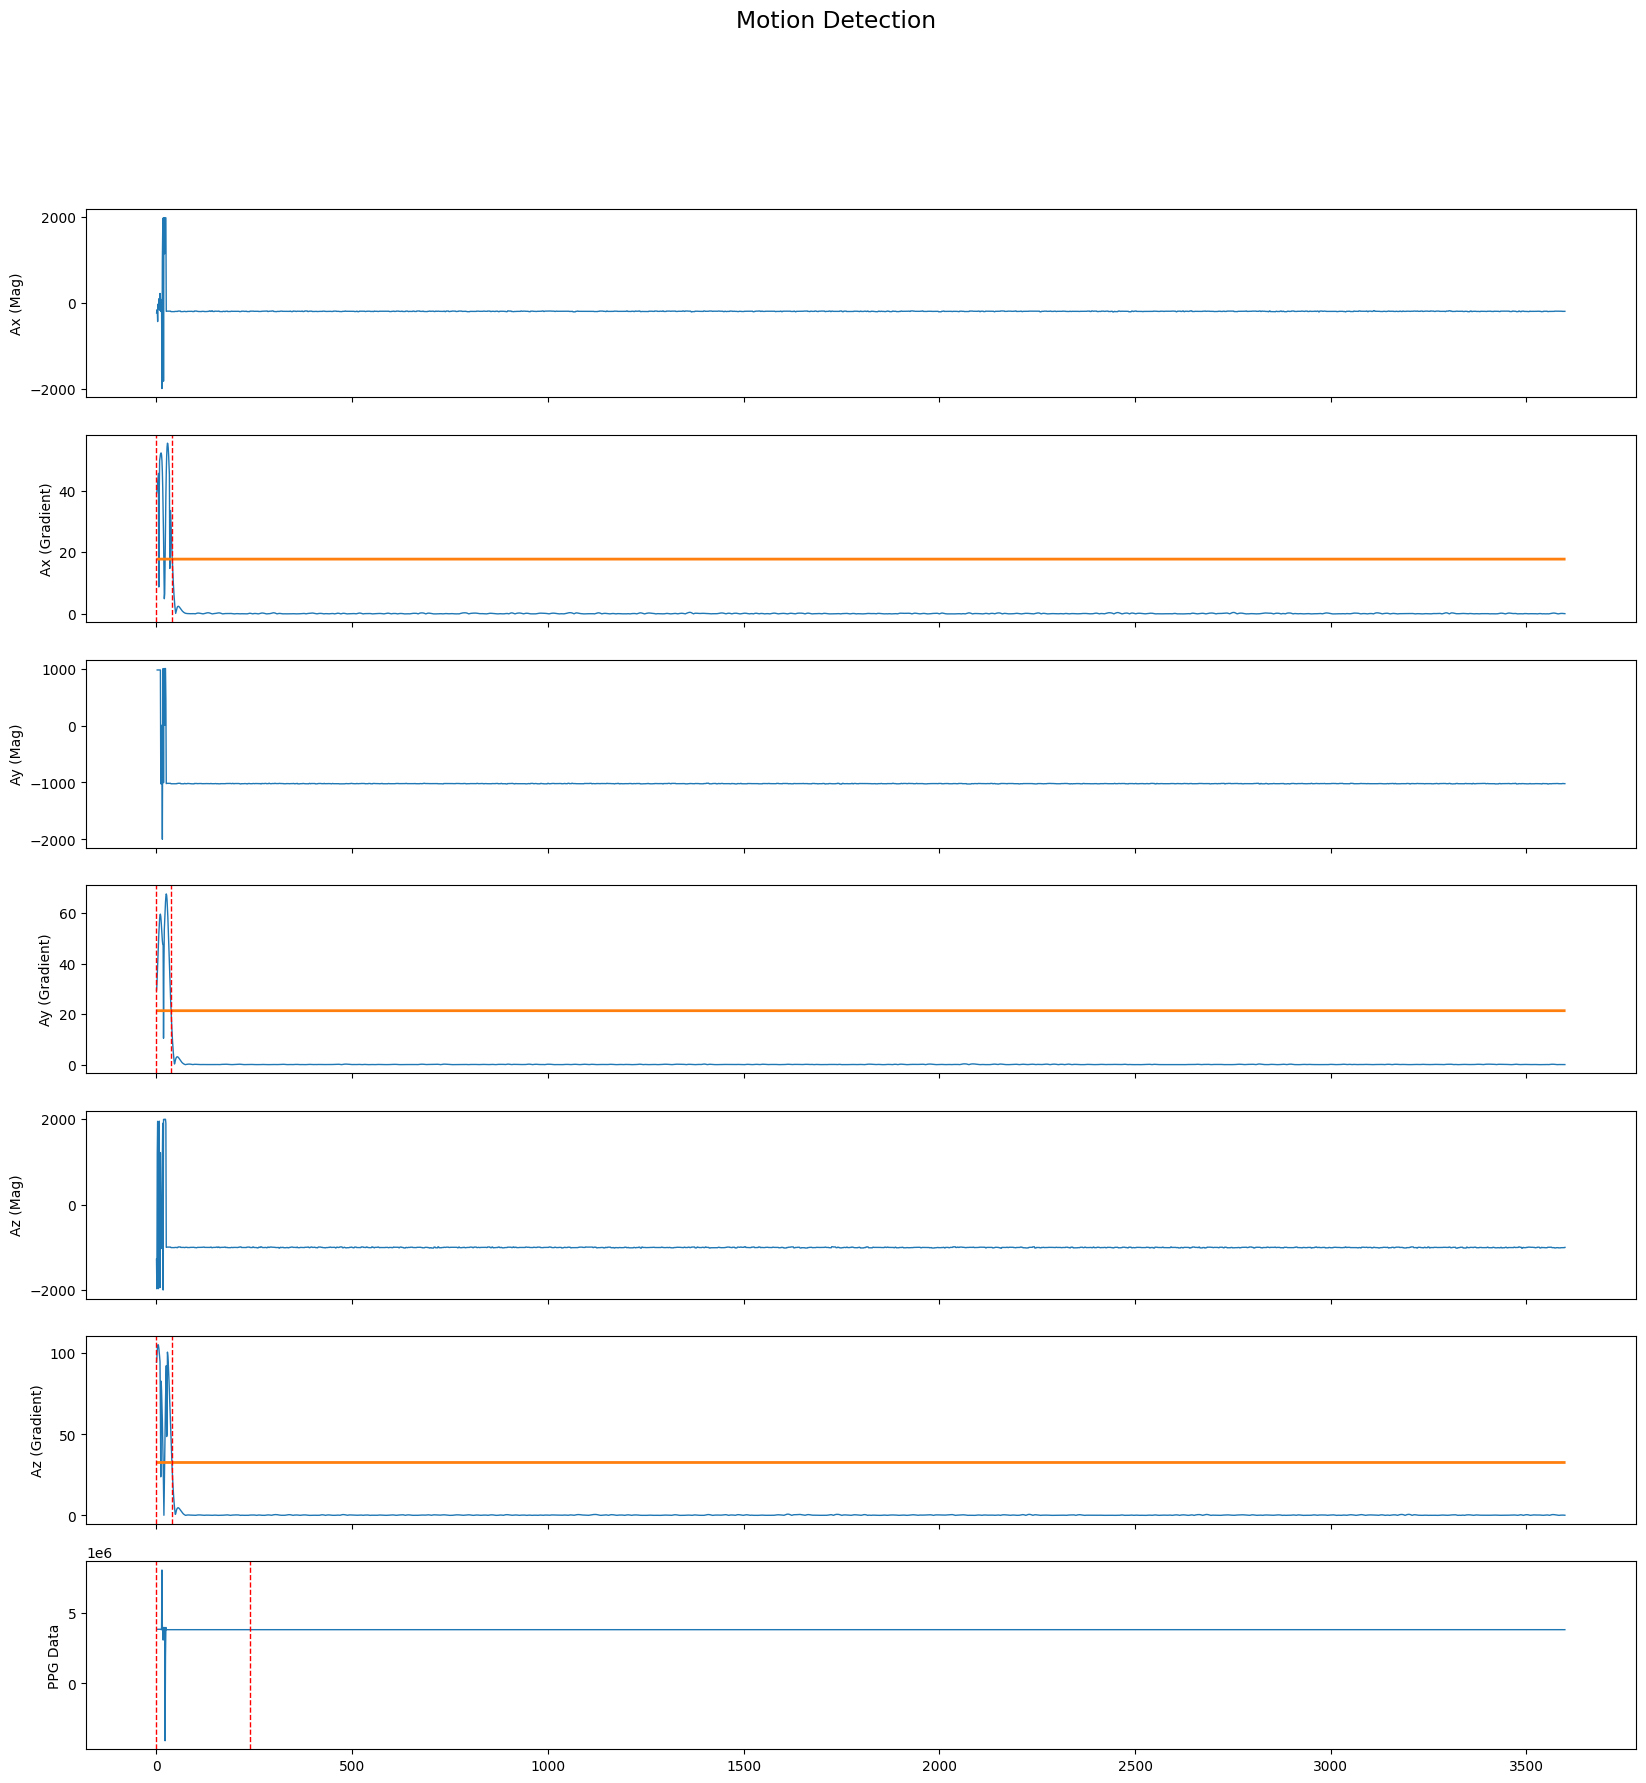

In [3]:
def detectMotion(ppg_data_csv_file_path):
    """
    detectMotion: This Function will detect motion ranges from given acceleration data. 
    :param in -  ppg_data_csv_file_path: CSV File path with PPG Raw Data value 
    :param out - Sample Ranges for Detected Motion (Also Saves Plot)
    """
    # Open CSV File Data
    df = pd.read_csv(ppg_data_csv_file_path, skiprows=15)

    # Read Acceleration Data
    acceleration_data = df[['Time (ms)', 'IR (counts)', 'Ax (mg)', 'Ay (mg)', 'Az (mg)']]
    A_x = acceleration_data['Ax (mg)']
    A_y = acceleration_data['Ay (mg)']
    A_z = acceleration_data['Az (mg)']
    ppg_data = acceleration_data['IR (counts)']
    max_samples = acceleration_data.index.size

    # Step 1: Preprocess the data using a low-pass filter
    #-------------------------------------------------------------
    fs = 200 # Hz
    fc = 5 # Hz
    order = 2
    b, a = signal.butter(order, fc/(fs/2), 'low')
    A_x = signal.filtfilt(b, a, A_x)
    A_y = signal.filtfilt(b, a, A_y)
    A_z = signal.filtfilt(b, a, A_z)

    A_x = np.abs(np.gradient(np.abs(A_x)))
    A_y = np.abs(np.gradient(np.abs(A_y)))
    A_z = np.abs(np.gradient(np.abs(A_z)))


    
    # Step 2:Set threshold value for all 3 Axis Acceleration data
    #-------------------------------------------------------------
    # 1. A_x (X Axis Computation)
    A_x_mean = np.mean(A_x)
    A_x_std = np.std(A_x)
    A_x_threshold = A_x_mean + 4 * A_x_std  # set the threshold as 3 times the standard deviation above the mean
    print("A_x_mean:", A_x_mean)
    print("A_x_std:", A_x_std)
    print("A_x_threshold:", A_x_threshold)

    # 2. A_y (Y Axis Computation)
    A_y_mean = np.mean(A_y)
    A_y_std = np.std(A_y)
    A_y_threshold = A_y_mean + 4 * A_y_std  # set the threshold as 3 times the standard deviation above the mean
    print("A_y_mean:", A_y_mean)
    print("A_y_std:", A_y_std)
    print("A_y_threshold:", A_y_threshold)


    # 3. A_z (Z Axis Computation)
    A_z_mean = np.mean(A_z)
    A_z_std = np.std(A_z)
    A_z_threshold = A_z_mean + 4 * A_z_std  # set the threshold as 3 times the standard deviation above the mean
    print("A_z_mean:", A_z_mean)
    print("A_z_std:", A_z_std)
    print("A_z_threshold:", A_z_threshold)




    # Step3: Find the Sample range of high fluctuations for All axis
    #-------------------------------------------------------------
    # 1. A_x (X Axis Computation)
    A_x_high_fluctuation_mask = A_x > A_x_threshold
    A_x_labelled_mask, A_x_num_labels = ndimage.label(A_x_high_fluctuation_mask)
    A_x_high_fluctuation_ranges = []
    for A_x_label_num in range(1, A_x_num_labels+1):
        A_x_label_indices = np.where(A_x_labelled_mask == A_x_label_num)[0]
        A_x_start_time = df.index[A_x_label_indices[0]]
        A_x_end_time = df.index[A_x_label_indices[-1]]
        A_x_high_fluctuation_ranges.append((A_x_start_time, A_x_end_time))

    # print(A_x_high_fluctuation_mask)
    # print(A_x_labelled_mask)
    # print(A_x_num_labels)
    # print(A_x_high_fluctuation_ranges)

    # 2. A_y (Y Axis Computation)
    A_y_high_fluctuation_mask = A_y > A_y_threshold
    A_y_labelled_mask, A_y_num_labels = ndimage.label(A_y_high_fluctuation_mask)
    A_y_high_fluctuation_ranges = []
    for A_y_label_num in range(1, A_y_num_labels+1):
        A_y_label_indices = np.where(A_y_labelled_mask == A_y_label_num)[0]
        A_y_start_time = df.index[A_y_label_indices[0]]
        A_y_end_time = df.index[A_y_label_indices[-1]]
        A_y_high_fluctuation_ranges.append((A_y_start_time, A_y_end_time))

    # print(A_y_high_fluctuation_mask)
    # print(A_y_labelled_mask)
    # print(A_y_num_labels)
    # print(A_y_high_fluctuation_ranges)

    # 3. A_z (Z Axis Computation)
    A_z_high_fluctuation_mask = A_z > A_z_threshold
    A_z_labelled_mask, A_z_num_labels = ndimage.label(A_z_high_fluctuation_mask)
    A_z_high_fluctuation_ranges = []
    for A_z_label_num in range(1, A_z_num_labels+1):
        A_z_label_indices = np.where(A_z_labelled_mask == A_z_label_num)[0]
        A_z_start_time = df.index[A_z_label_indices[0]]
        A_z_end_time = df.index[A_z_label_indices[-1]]
        A_z_high_fluctuation_ranges.append((A_z_start_time, A_z_end_time))

    # print(A_z_high_fluctuation_mask)
    # print(A_z_labelled_mask)
    # print(A_z_num_labels)
    # print(A_z_high_fluctuation_ranges)


    # Step4: Merge adjacent ranges of high fluctuations for all axis(Checks for 400 Samples)
    #---------------------------------------------------------------------------
    # 1. A_x (X Axis Computation)
    i = 0
    while i < len(A_x_high_fluctuation_ranges):
        if i < len(A_x_high_fluctuation_ranges) - 1:
            if A_x_high_fluctuation_ranges[i+1][0] - A_x_high_fluctuation_ranges[i][1] < 400:
                A_x_high_fluctuation_ranges[i] = (A_x_high_fluctuation_ranges[i][0], A_x_high_fluctuation_ranges[i+1][1])
                del A_x_high_fluctuation_ranges[i+1]
            else:
                i += 1
        else:
            break
    # Merged
    # print(A_x_high_fluctuation_ranges)

    # 2. A_y (Y Axis Computation)
    i = 0
    while i < len(A_y_high_fluctuation_ranges):
        if i < len(A_y_high_fluctuation_ranges) - 1:
            if A_y_high_fluctuation_ranges[i+1][0] - A_y_high_fluctuation_ranges[i][1] < 400:
                A_y_high_fluctuation_ranges[i] = (A_y_high_fluctuation_ranges[i][0], A_y_high_fluctuation_ranges[i+1][1])
                del A_y_high_fluctuation_ranges[i+1]
            else:
                i += 1
        else:
            break
    # Merged
    # print(A_y_high_fluctuation_ranges)

    # 3. A_z (Z Axis Computation)
    i = 0
    while i < len(A_z_high_fluctuation_ranges):
        if i < len(A_z_high_fluctuation_ranges) - 1:
            if A_z_high_fluctuation_ranges[i+1][0] - A_z_high_fluctuation_ranges[i][1] < 400:
                A_z_high_fluctuation_ranges[i] = (A_z_high_fluctuation_ranges[i][0], A_z_high_fluctuation_ranges[i+1][1])
                del A_z_high_fluctuation_ranges[i+1]
            else:
                i += 1
        else:
            break
    # Merged
    # print(A_z_high_fluctuation_ranges)


    # Step5: Merge ranges of of all axis to get final ranges
    #---------------------------------------------------------------------------
    # get a list of ranges of all 3 axis
    print("A_x_high_fluctuation_ranges: ", A_x_high_fluctuation_ranges)
    print("A_y_high_fluctuation_ranges: ", A_y_high_fluctuation_ranges)
    print("A_z_high_fluctuation_ranges: ", A_z_high_fluctuation_ranges)
    allAxisRanges = []
    for Range in A_x_high_fluctuation_ranges:
        allAxisRanges.append(Range)
    for Range in A_y_high_fluctuation_ranges:
        allAxisRanges.append(Range)
    for Range in A_z_high_fluctuation_ranges:
        allAxisRanges.append(Range)
    
    allAxisRangesMerged = merge_ranges(allAxisRanges)
    allAxisRangesMerged = remove_small_ranges(allAxisRangesMerged, fs/16)

    # Step6: Add 1 Seconds Padding to allAxisRangesMerged
    #---------------------------------------------------------------------------
    # So here we add 1 seconds (Sampling Frequency fs = 200Hz in our case)
    for i in range(len(allAxisRangesMerged)):
        allAxisRangesMerged[i] = (max(0, allAxisRangesMerged[i][0] - fs), min(max_samples, allAxisRangesMerged[i][1] + fs))

    # Step7 After padding make sure no ranges are overlapped if yes than merge it
    finalMotionRanges = merge_ranges(allAxisRangesMerged)


    # Plot the results
    fig, axs = plt.subplots(7, 1, figsize=(20,20), sharex=True)
    plt.style.use('fivethirtyeight')
    axs[0].plot(acceleration_data.index, acceleration_data['Ax (mg)'], linewidth=1)
    axs[0].set_ylabel('Ax (Mag)')
    axs[1].plot(acceleration_data.index, A_x, linewidth=1)
    axs[1].plot(acceleration_data.index, [A_x_threshold]*max_samples, linewidth=2)
    for A_x_high_fluctuation_range in A_x_high_fluctuation_ranges: 
        axs[1].axvline(A_x_high_fluctuation_range[0], color='red', linestyle='--', linewidth=1)
        axs[1].axvline(A_x_high_fluctuation_range[1], color='red', linestyle='--', linewidth=1)
    axs[1].set_ylabel('Ax (Gradient)')

    axs[2].plot(acceleration_data.index, acceleration_data['Ay (mg)'], linewidth=1)
    axs[2].set_ylabel('Ay (Mag)')
    axs[3].plot(acceleration_data.index, A_y, linewidth=1)
    axs[3].plot(acceleration_data.index, [A_y_threshold]*max_samples, linewidth=2)
    for A_y_high_fluctuation_range in A_y_high_fluctuation_ranges: 
        axs[3].axvline(A_y_high_fluctuation_range[0], color='red', linestyle='--', linewidth=1)
        axs[3].axvline(A_y_high_fluctuation_range[1], color='red', linestyle='--', linewidth=1)
    axs[3].set_ylabel('Ay (Gradient)')

    axs[4].plot(acceleration_data.index, acceleration_data['Az (mg)'], linewidth=1)
    axs[4].set_ylabel('Az (Mag)')
    axs[5].plot(acceleration_data.index, A_z, linewidth=1)
    axs[5].plot(acceleration_data.index, [A_z_threshold]*max_samples, linewidth=2)
    for A_z_high_fluctuation_range in A_z_high_fluctuation_ranges: 
        axs[5].axvline(A_z_high_fluctuation_range[0], color='red', linestyle='--', linewidth=1)
        axs[5].axvline(A_z_high_fluctuation_range[1], color='red', linestyle='--', linewidth=1)
    axs[5].set_ylabel('Az (Gradient)')

    axs[6].plot(acceleration_data.index, ppg_data, linewidth=1)
    for finalMotionRange in finalMotionRanges: 
        axs[6].axvline(finalMotionRange[0], color='red', linestyle='--', linewidth=1)
        axs[6].axvline(finalMotionRange[1], color='red', linestyle='--', linewidth=1)
    axs[6].set_ylabel('PPG Data')

    plt.suptitle('Motion Detection')
    PATH = ppg_data_csv_file_path + '(Motion_Detection_Plot).png'
    plt.savefig(PATH)

    return finalMotionRanges


motionRanges = detectMotion(CSV_FILE_PATH)
print("Motion Ranges: ", motionRanges)
 
    

### 2. Slice CSV File Based on Motion Ranges

In [4]:
def generateValidPPGDataCSVFiles(ppg_data_csv_file_path, motionRanges):
    """
    generateValidPPGDataCSVFiles: This Function will generate new CSV Files of Valid Data removing any motion based on motionRanges 
    :param in -  ppg_data_csv_file_path: CSV File path with PPG Raw Data value, motionRanges(See Details above def detectMotion(): )
    :param out - List of PATHs of CSV Files(Generates CSV Files in '\ValidCSVFiles' Folder) '2023-05-10-001S-22-05-32-S-P1.csv', '2023-05-10-001S-22-05-32-S-P2.csv'..
    """
    # Open CSV File Data
    df = pd.read_csv(ppg_data_csv_file_path, skiprows=15)

    # number of samples
    max_samples = df.index.size
    
    # Step1: Generating includeRages based on excludeRanges(In our cases it will be motionRanges)
    #---------------------------------------------------------------------------------------------
    exclude_ranges = motionRanges
    # Create a list of excluded indices
    excluded_indices = []
    for r in exclude_ranges:
        excluded_indices += list(range(r[0], r[1]+1))
    # Create a list of included ranges
    included_ranges = []
    start_index = 0
    for i in range(max_samples):
        if i in excluded_indices:
            if i > start_index:
                included_ranges.append((start_index, i-1))
            start_index = i + 1
    # Add the final included range, if applicable
    if start_index < max_samples:
        included_ranges.append((start_index, max_samples-1))
    # Print the list of included ranges
    print("Motion Ranges: ", exclude_ranges)
    print("No Motion Rages: ", included_ranges)

    # Step2: Generating Multiple CSV Files based on included_ranges (In our cases it will be No Motion Ranges)
    #---------------------------------------------------------------------------------------------
    valid_csv_files = []
    if not os.path.exists(CSV_VALID_FOLDER_NAME):
        os.makedirs(CSV_VALID_FOLDER_NAME)
    # Loop through the included ranges and create a new CSV file for each range
    for i, r in enumerate(included_ranges):
        # Create a new DataFrame that includes only the rows corresponding to the current included range
        df_range = df.iloc[r[0]:r[1]+1]
        # Set the name of the output CSV file
        output_file = f'{CSV_VALID_FOLDER_NAME}/{CSV_FILE_NAME}-P{i}.csv'
        print(f"Range: {r} --> {output_file}")
        
        # Write the DataFrame to a new CSV file
        df_range.to_csv(output_file, index=False)

        valid_csv_files.append(output_file) 

    return valid_csv_files

valid_csv_files = generateValidPPGDataCSVFiles(CSV_FILE_PATH, motionRanges)
print(valid_csv_files) 

Motion Ranges:  [(0, 240)]
No Motion Rages:  [(241, 3600)]
Range: (241, 3600) --> ValidCSVFiles/2023-05-11-001S-01-14-03-S-P0.csv
['ValidCSVFiles/2023-05-11-001S-01-14-03-S-P0.csv']


### 3. HeartRate Measurement  

2023-05-11-001S-01-14-03-S.csv -> HeartRate: Error
ValidCSVFiles/2023-05-11-001S-01-14-03-S-P0.csv -> HeartRate: 103.87754864930085


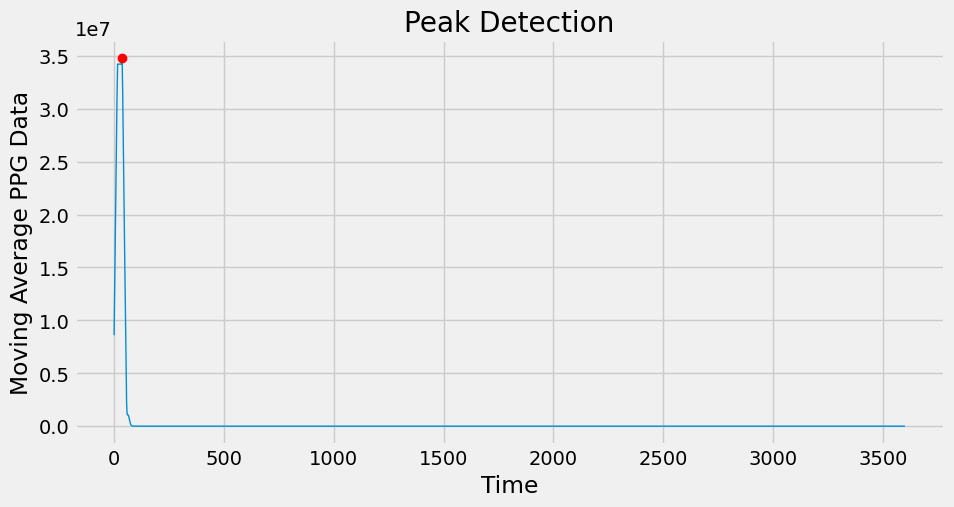

In [5]:
def measureHeartRate(ppg_data_csv_file_path, plot_save = False, no_skip_rows=0):
    """
    measureHeartRate: This Function will measure HeartRate from PPG Raw Data CSV File and saves peak detection plot in the same location. 
    :param in -  ppg_data_csv_file_path: CSV File path with PPG Raw Data value, plot_save: True: if user wants to save peak detection plot
    :param out - heartRate: Heart Rate in bpm or 0(Error)
    """ 
    ### Step0: Get Raw PPG signal
    #----------------------------------------------
    # Select channel from the dataset.
    channel = 'IR (counts)'

    # Open CSV File Data
    df = pd.read_csv(ppg_data_csv_file_path, skiprows=no_skip_rows)

    df.head()

    # Data Sampled at 200Hz
    ppg_data = df[['Time (ms)', channel]]

    max_samples = ppg_data[channel].size
    # max_samples = 5000

    ppg_data = ppg_data.iloc[:max_samples]

    ### Step1: Filter the PPG signal with a bandpass filter.
    #----------------------------------------------
    # Low-pass filter the raw signal to remove noise
    fs = 200  # Sampling frequency
    fc =  5 # Cutoff frequency
    b, a = butter(2, 2 * fc / fs, 'low')

    ppg_data_raw = ppg_data[channel]
    #Applying LP Filter to ppg_data[channel]
    ppg_data[channel] = filtfilt(b, a, ppg_data[channel])

    ppg_data_filtered = ppg_data[channel]

    ### Step2: Check signal quality by calculating Signal to Noise Ratio.
    #----------------------------------------------
    # Calculating SNR to find quality of a signal
    # Noise signal
    THRESHOLD = 25      #dB
    noise_data = ppg_data_raw - ppg_data_filtered

    signal_power = np.mean(np.abs(ppg_data_filtered)**2)
    noise_power = np.mean(np.abs(noise_data)**2)
    SNR = 10*np.log10(signal_power/noise_power)
    # print("SNR: ", SNR)
    if SNR < THRESHOLD:
        return "Error"
        # print("Signal Quality is Bad!")
    # else: 
        # print("Signal Quality is Good!")

    ### Step3: Differentiate the filtered signal
    #----------------------------------------------
    # Differentiate the filtered signal to emphasize the high-frequency components
    ppg_data[channel] = np.gradient(ppg_data[channel])

    ### Step4: Removing Abnormalities
    #----------------------------------------------  
    ppg_data_mean = np.mean(ppg_data[channel])
    ppg_data_std = np.std(ppg_data[channel])

    # print(ppg_data_mean)
    # print(ppg_data_std)

    threshold = ppg_data_mean + 2 * ppg_data_std  # set the threshold as 2 times the standard deviation above the mean
    # print(threshold)

    ppg_data[channel] = ppg_data[channel].apply(lambda x: x if abs(x) <= threshold else threshold)

    ### Step5: Square the differentiated  signal.
    #---------------------------------------------- 
    # Square the differentiated signal to enhance QRS complex
    ppg_data[channel] = np.square(ppg_data[channel])

    ### Step6: Integrate the squared signal with a sliding window.
    #---------------------------------------------- 
    # Apply a moving average integration to smooth the signal
    window_size = int(0.1 * fs)  # 20 window size
    window = np.ones(window_size) / float(window_size)
    ppg_data[channel] = np.convolve(ppg_data[channel], window, "same")

    ### Step7: Find the R-peaks in the integrated signal.
    #---------------------------------------------- 
    # Find peaks in the integrated signal
    ppg_peaks, _ = find_peaks(ppg_data[channel], distance=0.2*fs)
    # print("ppg_peaks:", ppg_peaks)
    # print("ppg_peaks size:", ppg_peaks.size)

    # Get a list of Amplitude of peaks
    ppg_peaks_amplitudes = [ppg_data[channel][i] for i in ppg_peaks]

    max_peak_amplitude = max(ppg_peaks_amplitudes)
    # print("max_peak_amplitude:", max_peak_amplitude)

    PEAK_AMPLITUDE_THRESHOLD = 0.4*max_peak_amplitude
    # print("PEAK_AMPLITUDE_THRESHOLD:", PEAK_AMPLITUDE_THRESHOLD)

    ppg_peaks_refined = []
    for ppg_peak in ppg_peaks:
        if(ppg_data[channel][ppg_peak] > PEAK_AMPLITUDE_THRESHOLD):
            # Amplitude is big enough to be considered as a peak
            ppg_peaks_refined.append(ppg_peak)

    # print(ppg_peaks_refined)

    ppg_peaks_refined_amplitudes = [ppg_data[channel][i] for i in ppg_peaks_refined]

    if plot_save:
        # Plot the diff_ppg data
        plt.figure(figsize=(10,5))
        plt.style.use('fivethirtyeight')
        #plot old plot
        plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
        # plot red dots with detected peaks
        plt.plot(ppg_peaks_refined, ppg_peaks_refined_amplitudes, 'ro')
        plt.title("Peak Detection")
        plt.xlabel('Time')
        plt.ylabel('Moving Average PPG Data')
        PATH = ppg_data_csv_file_path + '(Peaks_Plot).png'
        plt.savefig(PATH)

    ### Step8: Calculate the heart rate using the time difference between R-peaks.
    #----------------------------------------------  
    # Minimum number of Peaks Check
    total_time_seconds = max_samples/fs

    # Minimum Heartbeat = 25bpm
    # Maximum Heartbeat = 250bpm
    HEARTRATE_LOWER_THRESHOLD = 25
    HEARTRATE_HIGHER_THRESHOLD = 250

    # Minmum samples between two peaks

    MIN_NO_OF_PEAKS_THRESHOLD = (HEARTRATE_LOWER_THRESHOLD/60)*total_time_seconds
    MAX_NO_OF_PEAKS_THRESHOLD = (HEARTRATE_HIGHER_THRESHOLD/60)*total_time_seconds

    # print("MIN_NO_OF_PEAKS_THRESHOLD = ", MIN_NO_OF_PEAKS_THRESHOLD)
    # print("MAX_NO_OF_PEAKS_THRESHOLD = ", MAX_NO_OF_PEAKS_THRESHOLD)

    TOTAL_PEAKS_DETECTED = len(ppg_peaks_refined)
    # print("TOTAL_PEAKS_DETECTED = ", TOTAL_PEAKS_DETECTED)

    if (TOTAL_PEAKS_DETECTED < MIN_NO_OF_PEAKS_THRESHOLD) or (TOTAL_PEAKS_DETECTED > MAX_NO_OF_PEAKS_THRESHOLD)  or (max_samples < 400):
        return "Error"
        # print("Heart rate for file sample_ppg.csv: Error")
    else:
        # Compute the inter-beat interval (IBI) and heart rate (HR) from the peak locations
        ibi = np.diff(ppg_peaks_refined) / fs  # IBI in seconds
        hr = 60 / ibi  # HR in bpm

        mean_hr = np.mean(hr)      
        # Output the heart rate measurement
        return mean_hr
        # print("Heart rate for file sample_ppg.csv:", np.mean(hr), "bpm") 

#Measure Heart Rate For Raw CSV File.
hr = measureHeartRate(CSV_FILE_PATH, plot_save = True, no_skip_rows=15)
print(f"{CSV_FILE_PATH} -> HeartRate: {hr}")
# Measaure Heart Rate For All Valid CSV Files 
for valid_csv_file in valid_csv_files:
    try:
        hr = measureHeartRate(valid_csv_file)
    except:
        hr = "Error"
    print(f"{valid_csv_file} -> HeartRate: {hr}")
# print("HeartRate: ", measureHeartRate('2023-05-10-001S-22-05-32-S.csv'))
